<a href="https://kritikseth.github.io/ipynbtagredirect" target="_parent"><img src="https://raw.githack.com/kritikseth/kritikseth/master/assets/icons/kritik_ipynbtagredirect.svg" alt="Kritik Seth"/></a>

## Notebook- 4

* The Purpose of this notebook is to build an image classification model to distinguish between cat and dog images.
    * Training dataset- CIFAR-10
    * Testing dataset- ImageNet
    * Analyze performance of these versions - accuracy, error


* Perform error analysis on the outcome and explain it
* Finally make a flask app in this notebook itself and do a temporary deployment on ngrok.
* After the model is deployed as Flask app, collect data from user via flask app 
    * Use collected data to retrain model - Create new versions of model

### Classification

Cat vs Dog

In [1]:
!pip install swachhdata -q

     |████████████████████████████████| 133kB 27.0MB/s 
     |████████████████████████████████| 102kB 14.2MB/s 
     |████████████████████████████████| 266kB 51.6MB/s 
     |████████████████████████████████| 327kB 21.1MB/s 


In [2]:
import pandas as pd
import numpy as np

import keras

import cv2
import PIL.Image
from swachhdata.image import ImageNet, image_split

import random
random.seed(42)
from tqdm.auto import tqdm, trange

import matplotlib.pyplot as plt

## Fetching Data

In [3]:
def select(images, labels, indices):
    images_n = np.zeros((len(indices), images.shape[1], images.shape[2], images.shape[3]))
    labels_n, i = [], 0
    for ind in indices:
        images_n[i] = images[ind]
        labels_n.append(labels[ind])
        i += 1
    return images_n, labels_n

### Getting Train Data

In [4]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

train = np.concatenate((X_train, X_test), axis=0)
train = train.astype('float64')
train_labels = np.concatenate((y_train, y_test), axis=0).tolist()
train_labels = [item for sublist in train_labels for item in sublist]

170500096/170498071 [==============================] - 2s 0us/step


In [5]:
label_id = {'Cat': 3, 'Airplane': 0, 'Automobile': 1, 'Bird': 2, 'Deer': 4, 'Dog': 5, 'Frog': 6, 'Horse': 7, 'Ship': 8, 'Truck': 9}
id_label = {id: label for label, id in label_id.items()}

In [6]:
train_labels = [id_label[label] for label in train_labels]

In [7]:
cat_dog_indices = [i for i, x in enumerate(train_labels) if x == 'Cat' or x == 'Dog']

In [8]:
train, train_labels = select(train, train_labels, cat_dog_indices)

### Getting Test Data

In [9]:
indt = {'Cat': 'n02124075', 'Dog': 'n02106662'}

In [10]:
img_rows, img_cols = 32, 32
input_shape = (img_rows, img_cols, 3)

num_test = num_valid = 64
test_per_cat = num_test//len(indt)
valid_per_cat = num_valid//len(indt)

input_dim = (num_test, img_rows, img_cols, 3)

BATCH_SIZE = 64

In [11]:
imgnet = ImageNet(img_shape=input_shape, total_img=num_test*2, verbose=1)

In [12]:
test, test_labels = imgnet.fetch(indt)

In [13]:
catVdog = {'Cat': 0, 'Dog': 1}
train_labels = [catVdog[label] for label in train_labels]
test_labels = [catVdog[label] for label in test_labels]

In [14]:
zero = [i for i, value in enumerate(train_labels) if value == 0]
one = random.sample([i for i, value in enumerate(train_labels) if value == 1], len(zero))

train_indices = zero + one
train, train_labels = select(train, train_labels, train_indices)

In [15]:
zero = [i for i, value in enumerate(test_labels) if value == 0]
one = random.sample([i for i, value in enumerate(test_labels) if value == 1], len(zero))

test_indices = zero + one
test, test_labels = select(test, test_labels, test_indices)

In [16]:
test, val, test_labels, val_labels = image_split(test, test_labels, split_size=0.5, random_state=123)

In [17]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

In [18]:
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=10,
                                   zoom_range=0.10,
                                   width_shift_range=0.05,
                                   height_shift_range=0.05,
                                   shear_range=0.05,
                                   fill_mode='nearest',
                                   horizontal_flip=True,
                                   brightness_range=[0.1,0.5])

test_datagen = ImageDataGenerator(rescale=1/255.0)

In [19]:
train_aug = train_datagen.flow(train, train_labels,
                               shuffle=False,
                               seed=42)

valid_aug = test_datagen.flow(val, val_labels,
                              shuffle=False,
                              seed=42)

test_aug = test_datagen.flow(test, test_labels,
                             shuffle=False,
                             seed=42)

In [20]:
import tensorflow as tf
import keras
from tqdm.keras import TqdmCallback

In [21]:
def get_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(),
        

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=512, activation='relu'),
        tf.keras.layers.Dense(units=256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=64, activation='relu'),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
        ])
    return model

In [22]:
model = get_model()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [23]:
ch = tf.keras.callbacks.ModelCheckpoint(filepath='model.h5',
                                        monitor='val_loss',
                                        mode='auto',
                                        save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      min_delta=0.05,
                                      patience=1,
                                      mode='min',
                                      restore_best_weights=True)

lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                          factor=0.01,
                                          patience=1,
                                          mode='min')

class MonitorAccLoss(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_loss') < 0.5) and (logs.get('val_acc') > 0.75):
            print('\nOptimum Loss & Accuracy achieved, cancelling training!')
            self.model.stop_training = True

mal = MonitorAccLoss()

In [24]:
model.fit(train_aug, validation_data=valid_aug, epochs=10, callbacks=[TqdmCallback(), ch, es, lr, mal], verbose=0)

In [25]:
model.save('model.h5',save_format='h5')

In [26]:
model.evaluate(test_aug)
ypred = model.predict_classes(test_aug)

2/2 [==============================] - 0s 5ms/step - loss: 0.6954 - acc: 0.5000


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [27]:
confusion_matrix(test_labels, ypred)

array([[32,  0],
       [32,  0]])

In [28]:
print(classification_report(test_labels, ypred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67        32
           1       0.00      0.00      0.00        32

    accuracy                           0.50        64
   macro avg       0.25      0.50      0.33        64
weighted avg       0.25      0.50      0.33        64



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Error Analysis

<tbody>
<tr>
<td>&nbsp;</td>
<td>Accuracy&nbsp;</td>
<td>Loss&nbsp;</td>
</tr>
<tr>
<td>Training</td>
<td>0.613</td>
<td>0.683&nbsp;</td>
</tr>
<tr>
<td>Validation&nbsp;</td>
<td>0.514</td>
<td>0.723&nbsp;</td>
</tr>
<tr>
<td>Testing</td>
<td>0.5</td>
<td>NA&nbsp;</td>
</tr>
</tbody>

---

*Here for all practical purposes we will assume Human error to be 0*

* Human Error- 0%
* Training Error- 38.6%
* Development Error- 48.6%

Since Training Error >> Human Error (38.6), we will first focus on removing the **avoidable bias** using the following methods:
1. Train bigger model
2. Trian longer / better optimization
3. Hyperparameter Tuning

Since Development Error >> Training Error (10.0), we will also have to focus on reducing the **variance**, for which we will use the following methods:
1. Train on more data (not possible in our scenario due to problem statement constraints)
2. Regularization
3. Hyperparameter Tuning
4. Data Augmentation

* Manual Testing- 50.0%

Since the Training Error << Development Error we can safely conclude that the model has been **overfitted** on the training data which is very different from the testing and validation data

# Flask Application

In [29]:
!pip install flask gevent requests pillow flask-ngrok -q

     |████████████████████████████████| 5.5MB 13.6MB/s 
     |████████████████████████████████| 245kB 49.8MB/s 
     |████████████████████████████████| 163kB 62.4MB/s 


In [30]:
html = '''<!DOCTYPE HTML>
<html lang="en">
    <head>
        <meta http-equiv="Content-Type" content="text/html; charset=utf-8" />
        <title>Cats V Dogs</title>
        <link rel="stylesheet" href="https://codepen.io/chriddyp/pen/bWLwgP.css">
    </head>

    <body>

        <br>
        <center><h1 id="title">Cats V Dogs</h1></center>
        <br>
        <form name="image_form" action="/" method="POST" enctype="multipart/form-data">
            <div style="width: 800px; margin: 0 auto; justify-content: center; align-items: center">

                <div style="width: 280px; height: 280px; float:left; border:1px solid rgb(100, 100, 100); font-size: 280px; line-height: 280px; text-align: center">
                    <img src="" id="preview" style="width: 280px; height: 280px; float:left;">
                </div>

                <div style="width: 230px; height: 280px; float: left; position:relative">
                    <input type="file" name="file" id="filetag" accept="image/png, image/jpeg, image/jpg" style="width: 75%; position:absolute; top: 10%; left: 12%">
                    <input id="cat" class="cust_button" name="button" type="submit" value="Cat" style="width: 75%; position:absolute; top: 30%; left: 12%"/>
                    <input id="dog" class="cust_button" name="button" type="submit" value="Dog" style="width: 75%; position:absolute; top: 50%; left: 12%"/>
                    <input id="predict" class="cust_button" name="button" type="submit" value="Predict" style="width: 75%; position:absolute; top: 70%; left: 12%"/>
                </div>

                <div style="width: 280px; height: 280px; float:left; border:1px solid black; font-size: 60px; line-height: 80px; text-align: center">
                    <span id="num" style="">{{pred}}</span>
                </div>
            </div>
        </form>
    </body>

    <script>
        var fileTag = document.getElementById("filetag"),
            preview = document.getElementById("preview");
            
        fileTag.addEventListener("change", function() {
        changeImage(this);
        });

        function changeImage(input) {
        var reader;

        if (input.files && input.files[0]) {
            reader = new FileReader();

            reader.onload = function(e) {
            preview.setAttribute('src', e.target.result);
            }

            reader.readAsDataURL(input.files[0]);
        }
        }
    </script>

</html>
'''

In [31]:
!mkdir templates
!mkdir uploads
HTML_file = open('/content/templates/index.html', 'w')
HTML_file.write(html)
HTML_file.close()

In [32]:
import os
import cv2
import keras
from flask import Flask, render_template, request
from flask_ngrok import run_with_ngrok
import numpy as np

app = Flask(__name__, static_folder='/content/templates')
run_with_ngrok(app)

app.config['UPLOADS'] = 'uploads'

cnn = keras.models.load_model('/content/model.h5')

def process(file):
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (32, 32))
    image = np.resize(image, (1, 32, 32, 3))
    image = 1-image
    image = image.reshape(1, 32, 32, 3)
    return image

def retrain(label, image, model):
    model.fit(test_datagen.flow(image, [label]), epochs=1)
    return model

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/', methods=['GET', 'POST'])
def predict():
    global cnn
    if request.method == 'POST':
        file = request.files['file']
        filepath = os.path.join(app.config['UPLOADS'], file.filename)
        file.save(filepath)
        image = process(filepath)
        btype = request.form['button']
        if btype == 'Cat':
            cnn = retrain(0, image, cnn)
            prediction = 'Cat\nImage\nTrained'
        elif btype == 'Dog':
            cnn = retrain(1, image, cnn)
            prediction = 'Dog\nImage\nTrained'
        elif btype == 'Predict':
            prediction = cnn.predict_classes(image)
            if int(prediction[0][0]) == 0:
                prediction = 'Cat'
            else:
                prediction = 'Dog'
    return render_template('index.html', pred=prediction)

if __name__ == '__main__':
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://752bfe59d0f1.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


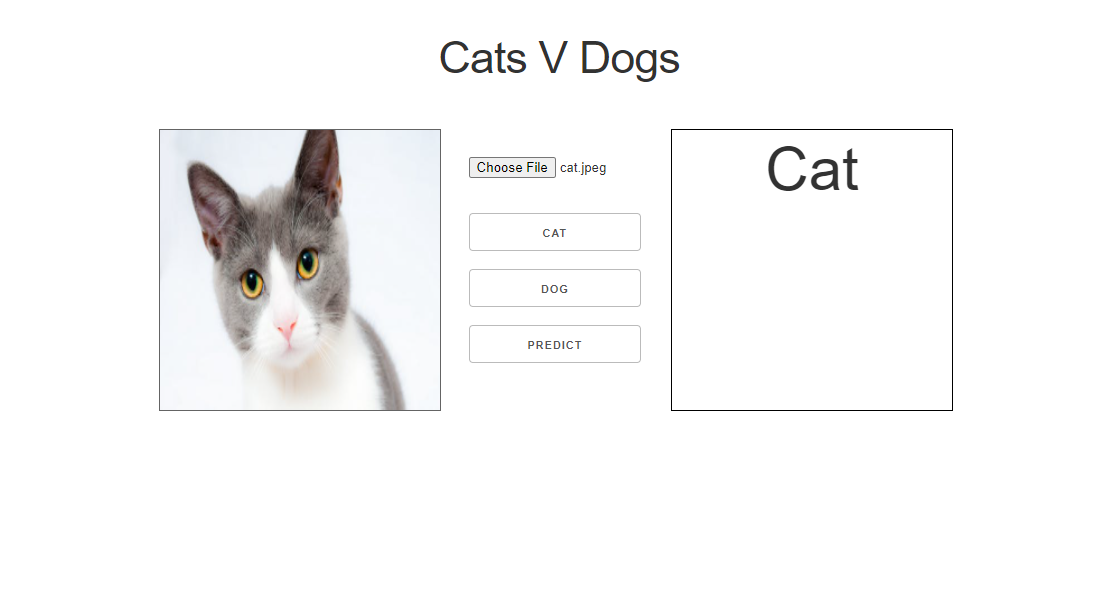

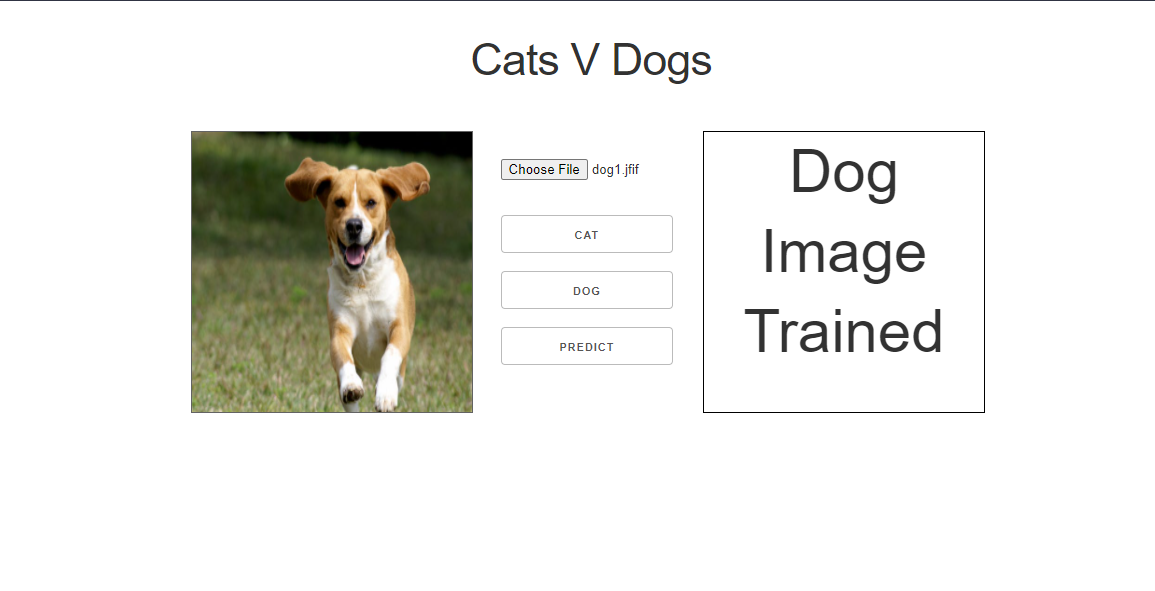

## Conclusions

Our model is grossly inaccuracte when predicting data it has not seen (performing poorly at only 50% accuracy)

Model retraining would be ideal and the best solution to this problem, hence we will introduce it fresh cat and dog images which vary from the ones that model is already trained on.